# Dimensionality reduction on trial features

In [1]:

""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
import seaborn as sns
from collections import defaultdict
import pandas as pd
from matplotlib import colors as mcolors
from one.api import ONE
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, Normalizer
import collections

# --Machine learning and statistics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.cluster import KMeans
import umap

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//2_fit_models/'
functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import concatenate_sessions, fix_discontinuities
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//3_postprocess_results/'
functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//3_postprocess_results/'
os.chdir(functions_path)
from postprocessing_functions import remove_states_str, state_identifiability
from plotting_functions import align_bin_design_matrix, states_per_trial_phase, broader_label, traces_over_few_sates

# one = ONE(base_url='https://alyx.internationalbrainlab.org')
one = ONE(mode='remote')

In [2]:
functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial/4_analyses/'
os.chdir(functions_path)
states_trial_type = pd.read_pickle("./states_trial_type.pkl")
extended = pd.read_pickle("./mouse_movements_df.pkl")
extended_short = extended[['trial_id', 'Bin', 'session', 'virtual_response', 'ballistic']]

In [3]:
merged = states_trial_type.merge(extended_short, on=['trial_id', 'Bin', 'session']).drop_duplicates()


## Extend states

In [4]:
extended_states = merged.copy()
# New wheel states
# Wheel movement, no response
move_no_resp = extended_states.loc[(extended_states['virtual_response'].isna()) &
                                   (extended_states['identifiable_states'].str[0]=='1'), 'identifiable_states']
extended_states.loc[(extended_states['virtual_response'].isna()) &
                    (extended_states['identifiable_states'].str[0]=='1'), 
                    'identifiable_states'] = 'n' + move_no_resp.str[1:]
# Response L, non ballistic
left_non_ballistic = extended_states.loc[(extended_states['virtual_response']==1.) &
                                         (extended_states['ballistic']==False) &
                                         (extended_states['identifiable_states'].str[0]=='1'), 'identifiable_states']
extended_states.loc[(extended_states['virtual_response']==1.) &
                    (extended_states['ballistic']==False) &
                    (extended_states['identifiable_states'].str[0]=='1'), 
                    'identifiable_states'] = 'l' + left_non_ballistic.str[1:]
# Response R, non ballistic
right_non_ballistic = extended_states.loc[(extended_states['virtual_response']==-1.) &
                                          (extended_states['ballistic']==False) &
                                          (extended_states['identifiable_states'].str[0]=='1'), 'identifiable_states']
extended_states.loc[(extended_states['virtual_response']==-1.) &
                    (extended_states['ballistic']==False) &
                    (extended_states['identifiable_states'].str[0]=='1'), 
                    'identifiable_states'] = 'r' + right_non_ballistic.str[1:]

# Response L, ballistic
left_ballistic = extended_states.loc[(extended_states['virtual_response']==1.) &
                                     (extended_states['ballistic']==True) &
                                     (extended_states['identifiable_states'].str[0]=='1'), 'identifiable_states']
extended_states.loc[(extended_states['virtual_response']==1.) &
                    (extended_states['ballistic']==True) &
                    (extended_states['identifiable_states'].str[0]=='1'), 
                    'identifiable_states'] = 'L' + left_ballistic.str[1:]

# Response R, non ballistic
right_ballistic = extended_states.loc[(extended_states['virtual_response']==-1.) &
                                      (extended_states['ballistic']==True) &
                                      (extended_states['identifiable_states'].str[0]=='1'), 'identifiable_states']
extended_states.loc[(extended_states['virtual_response']==-1.) &
                    (extended_states['ballistic']==True) &
                    (extended_states['identifiable_states'].str[0]=='1'), 
                    'identifiable_states'] = 'R' + right_ballistic.str[1:]


In [38]:
extended_states = merged.copy()
# New wheel states
# Wheel movement, no response
move_no_resp = extended_states.loc[(extended_states['virtual_response'].isna()) &
                                   (extended_states['identifiable_states'].str[0]=='1'), 'identifiable_states']
extended_states.loc[(extended_states['virtual_response'].isna()) &
                    (extended_states['identifiable_states'].str[0]=='1'), 
                    'identifiable_states'] = 'n' + move_no_resp.str[1:]
# Response L, non ballistic
left_non_ballistic = extended_states.loc[(extended_states['virtual_response']==1.) &
                                         (extended_states['ballistic']==False) &
                                         (extended_states['identifiable_states'].str[0]=='1'), 'identifiable_states']
extended_states.loc[(extended_states['virtual_response']==1.) &
                    (extended_states['ballistic']==False) &
                    (extended_states['identifiable_states'].str[0]=='1'), 
                    'identifiable_states'] = 'b' + left_non_ballistic.str[1:]
# Response R, non ballistic
right_non_ballistic = extended_states.loc[(extended_states['virtual_response']==-1.) &
                                          (extended_states['ballistic']==False) &
                                          (extended_states['identifiable_states'].str[0]=='1'), 'identifiable_states']
extended_states.loc[(extended_states['virtual_response']==-1.) &
                    (extended_states['ballistic']==False) &
                    (extended_states['identifiable_states'].str[0]=='1'), 
                    'identifiable_states'] = 'b' + right_non_ballistic.str[1:]

# Response L, ballistic
left_ballistic = extended_states.loc[(extended_states['virtual_response']==1.) &
                                     (extended_states['ballistic']==True) &
                                     (extended_states['identifiable_states'].str[0]=='1'), 'identifiable_states']
extended_states.loc[(extended_states['virtual_response']==1.) &
                    (extended_states['ballistic']==True) &
                    (extended_states['identifiable_states'].str[0]=='1'), 
                    'identifiable_states'] = 'B' + left_ballistic.str[1:]

# Response R, non ballistic
right_ballistic = extended_states.loc[(extended_states['virtual_response']==-1.) &
                                      (extended_states['ballistic']==True) &
                                      (extended_states['identifiable_states'].str[0]=='1'), 'identifiable_states']
extended_states.loc[(extended_states['virtual_response']==-1.) &
                    (extended_states['ballistic']==True) &
                    (extended_states['identifiable_states'].str[0]=='1'), 
                    'identifiable_states'] = 'B' + right_ballistic.str[1:]


## Parameters

In [39]:
bin_size = 0.1
multiplier = 1/bin_size

In [40]:
states_trial_type = extended_states.copy()

In [41]:
def groupby(vars, use_data):
    # Step 1: Group and count occurrences
    count = pd.DataFrame(use_data.groupby(vars)['identifiable_states'].count())  #  'correct',

    # Step 2: Reset index to bring the grouping columns back into the DataFrame
    count = count.reset_index(level=list(np.arange(0, len(vars)-1, 1)))

    # Rename the count column
    count.rename(columns={'identifiable_states': 'count'}, inplace=True)

    # Step 3: Calculate the total counts for each group of 'mouse_name', 'session', 'label'
    count['total'] = count.groupby(vars[:-1])['count'].transform('sum')  # 'broader_label'

    # Step 4: Compute the relative frequency
    count['relative_frequency'] = count['count'] / count['total']

    # Drop the 'total' column if it's no longer needed
    count = count.drop(columns=['total'])

    return count


In [42]:
# Fix wrong string in wsls
states_trial_type.loc[states_trial_type['wsls']=='ls', 'wsls'] = 'lst'

# Compute features and organize sample keys

In [43]:
trial_type_agg = ['wsls', 'correct_str', 'choice', 'contrast_str']
trial_type_agg = ['correct_str', 'contrast_str', 'wsls', 'choice']
trial_type_agg = ['correct_str', 'contrast_str', 'wsls']
trial_type_agg = ['correct_str', 'perseverence']
# trial_type_agg = ['wsls']


order_0 = ['left', 'right']
order_1 = ['correct', 'incorrect']
order_1_1 = ['1.0',
    '0.25', 
    '0.125', 
    '0.0625', 
    '0.0']
order_1_2 = ['wst',
    'lst', 
    'wsh', 
    'lsh']


order_2 = ['correct 1.0',
    'correct 0.25', 
    'correct 0.125', 
    'correct 0.0625', 
    'correct 0.0', 
    'incorrect 1.0', 
    'incorrect 0.25', 
    'incorrect 0.125', 
    'incorrect 0.0625', 
    'incorrect 0.0']
order_2_1 = ['correct 1.0',
    'correct 0.25', 
    'correct 0.125', 
    'correct 0.0625', 
    'correct 0.0', 
    'incorrect 0.0', 
    'incorrect 0.0625', 
    'incorrect 0.125', 
    'incorrect 0.25', 
    'incorrect 1.0']
order_3 = ['correct 1.0 left', 'correct 1.0 right', 
    'correct 0.25 left', 'correct 0.25 right',
    'correct 0.125 left', 'correct 0.125 right',
    'correct 0.0625 left', 'correct 0.0625 right',
    'correct 0.0 left', 'correct 0.0 right',
    'incorrect 1.0 left', 'incorrect 1.0 right', 
    'incorrect 0.25 left', 'incorrect 0.25 right',
    'incorrect 0.125 left', 'incorrect 0.125 right',
    'incorrect 0.0625 left', 'incorrect 0.0625 right',
    'incorrect 0.0 left', 'incorrect 0.0 right']

order_4 = ['correct 1.0 wst', 'correct 1.0 wsh', 'correct 1.0 lst', 'correct 1.0 lsh', 
    'correct 0.25 wst', 'correct 0.25 wsh', 'correct 0.25 lst', 'correct 0.25 lsh', 
    'correct 0.125 wst', 'correct 0.125 wsh', 'correct 0.125 lst', 'correct 0.125 lsh',
    'correct 0.0625 wst', 'correct 0.0625 wsh',   'correct 0.0625 lst', 'correct 0.0625 lsh',
    'correct 0.0 wst', 'correct 0.0 wsh', 'correct 0.0 lst', 'correct 0.0 lsh',
    'incorrect 1.0 wst', 'incorrect 1.0 wsh',  'incorrect 1.0 lst', 'incorrect 1.0 lsh', 
    'incorrect 0.25 wst', 'incorrect 0.25 wsh', 'incorrect 0.25 lst', 'incorrect 0.25 lsh',
    'incorrect 0.125 wst', 'incorrect 0.125 wsh', 'incorrect 0.125 lst', 'incorrect 0.125 lsh',
    'incorrect 0.0625 wst', 'incorrect 0.0625 wsh',  'incorrect 0.0625 lst', 'incorrect 0.0625 lsh',
    'incorrect 0.0 wst', 'incorrect 0.0 wsh', 'incorrect 0.0 lst', 'incorrect 0.0 lsh']

order_5 = ['correct wst', 'correct lst', 'correct wsh', 'correct lsh',
    'incorrect wst', 'incorrect lst',  'incorrect wsh', 'incorrect lsh']

order_6 = ['correct stay', 'correct shift',
    'incorrect stay', 'incorrect shift']

use_order = order_6

In [44]:
""" Define trial types"""
states_trial_type['correct_str'] = states_trial_type['correct']
states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
states_trial_type.loc[states_trial_type['correct_str']==0., 'correct_str'] = 'incorrect'
states_trial_type['contrast_str'] = states_trial_type['contrast'].astype(str)
states_trial_type['perseverence'] = states_trial_type['wsls'].copy()
states_trial_type.loc[states_trial_type['wsls'].isin(['wst', 'lst']), 'perseverence']  = 'stay'
states_trial_type.loc[states_trial_type['wsls'].isin(['wsh', 'lsh']), 'perseverence']  = 'shift'
states_trial_type['trial_type'] = states_trial_type[trial_type_agg].agg(' '.join, axis=1)
states_trial_type['trial_str'] = states_trial_type['trial_id'].astype(str)
states_trial_type['sample'] = states_trial_type[['session', 'trial_str']].agg(' '.join, axis=1)

""" Sort in intuitive way to help with visualization """

""" Frequency """
vars = ['sample', 'trial_type', 'broader_label', 'mouse_name']
extended_vars = ['sample', 'trial_type', 'broader_label', 'mouse_name', 'identifiable_states']
count = groupby(extended_vars, states_trial_type)

# Pivot the DataFrame
freq_df = count.reset_index().pivot(index=['sample', 'trial_type', 'mouse_name'], columns=['identifiable_states', 'broader_label'], values='relative_frequency')
# To flatten the column MultiIndex
freq_df.columns = ['_'.join(col).strip() for col in freq_df.columns.values]
freq_df[freq_df.isna()] = 0

""" Timings """
times = pd.DataFrame(states_trial_type.groupby(['sample', 'trial_type', 'mouse_name'])['reaction', 'response', 'elongation'].mean()).reset_index()

# Merge
merged_df = freq_df.merge(times, on=['sample', 'trial_type', 'mouse_name'])

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_86808/1640269079.py:27: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  times = pd.DataFrame(states_trial_type.groupby(['sample', 'trial_type', 'mouse_name'])['reaction', 'response', 'elongation'].mean()).reset_index()


In [45]:
merged_df.keys()

Index(['sample', 'trial_type', 'mouse_name', '000_Quiescence', '000_Stimulus',
       'B11_Choice', '011_ITI', 'B11_ITI', '011_Quiescence', 'B01_Quiescence',
       'B01_Stimulus', '011_Stimulus', '000_ITI', 'B00_ITI', 'B01_ITI',
       'B11_Quiescence', 'B11_Stimulus', 'n11_Quiescence', 'n11_ITI',
       'B00_Stimulus', '000_Choice', 'n00_Choice', 'n11_Choice',
       'n01_Stimulus', 'n11_Stimulus', 'b11_ITI', '011_Choice', 'n00_ITI',
       'B00_Choice', 'B01_Choice', 'n01_Choice', 'n00_Quiescence',
       'n01_Quiescence', 'n01_ITI', 'b11_Choice', 'b01_Stimulus',
       'b11_Stimulus', 'b01_Choice', 'b00_ITI', 'b00_Choice', '001_Quiescence',
       'b01_Quiescence', '001_ITI', 'b01_ITI', '001_Stimulus', '001_Choice',
       'b11_Quiescence', 'B00_Quiescence', 'n00_Stimulus', 'B10_ITI',
       'n10_Choice', 'n10_ITI', 'B10_Choice', 'B10_Quiescence', 'b10_Choice',
       'b10_Quiescence', 'b10_Stimulus', 'n10_Stimulus', 'n10_Quiescence',
       'B10_Stimulus', 'b00_Quiescence', '010_I

## Prepare design matrix

In [46]:
var_names = ['000_Quiescence', '000_Stimulus', '111_Choice',
       '011_ITI', '111_ITI', '011_Quiescence', '101_Quiescence',
       '101_Stimulus', '011_Stimulus', '000_ITI', '100_ITI', '101_ITI',
       '111_Quiescence', '111_Stimulus', '100_Stimulus', '000_Choice',
       '100_Choice', '011_Choice', '101_Choice', '100_Quiescence',
       '001_Quiescence', '001_ITI', '001_Stimulus', '001_Choice', '110_ITI',
       '110_Choice', '110_Quiescence', '110_Stimulus', '010_ITI', '010_Choice',
       '010_Quiescence', '010_Stimulus', 'Choice', 'ITI', 'Quiescence',
       'Stimulus', 'reaction', 'response', 'elongation']

var_names = ['000_Quiescence', '000_Stimulus', '111_Choice',
       '011_ITI', '111_ITI', '011_Quiescence', '101_Quiescence',
       '101_Stimulus', '011_Stimulus', '000_ITI', '100_ITI', '101_ITI',
       '111_Quiescence', '111_Stimulus', '100_Stimulus', '000_Choice',
       '100_Choice', '011_Choice', '101_Choice', '100_Quiescence',
       '001_Quiescence', '001_ITI', '001_Stimulus', '001_Choice', '110_ITI',
       '110_Choice', '110_Quiescence', '110_Stimulus', '010_ITI', '010_Choice',
       '010_Quiescence', '010_Stimulus', 'reaction', 'response', 'elongation']

var_names = ['000_Quiescence', '000_Stimulus',
       'R11_Choice', 'n11_Choice', '011_ITI', 'R11_ITI', 'n11_ITI',
       '011_Quiescence', 'R01_Quiescence', 'n01_Quiescence', 'R01_Stimulus',
       'n01_Stimulus', '011_Stimulus', '000_ITI', 'R00_ITI', 'R01_ITI',
       'n00_ITI', 'n01_ITI', 'R11_Quiescence', 'n11_Quiescence',
       'R11_Stimulus', 'n11_Stimulus', 'L11_Choice', 'L11_ITI', 'L01_Stimulus',
       'L11_Stimulus', 'R00_Stimulus', 'n00_Stimulus', '000_Choice',
       'n00_Choice', 'r11_ITI', '011_Choice', 'R00_Choice', 'R01_Choice',
       'n01_Choice', 'L01_Quiescence', 'l11_ITI', 'n00_Quiescence',
       'L11_Quiescence', 'L00_Stimulus', 'l11_Choice', 'l01_Stimulus',
       'l11_Stimulus', 'L00_Choice', 'L01_Choice', 'l01_Choice', 'r11_Choice',
       'r11_Stimulus', 'L01_ITI', 'r00_ITI', 'r00_Choice', 'r01_Stimulus',
       'r01_Choice', '001_Quiescence', 'r01_Quiescence', '001_ITI', 'r01_ITI',
       '001_Stimulus', '001_Choice', 'r11_Quiescence', 'l01_Quiescence',
       'l11_Quiescence', 'l00_ITI', 'l01_ITI', 'R00_Quiescence', 'L00_ITI',
       'R10_ITI', 'n10_ITI', 'n10_Choice', 'R10_Choice', 'R10_Quiescence',
       'n10_Quiescence', 'l10_Choice', 'l10_Quiescence', 'l10_Stimulus',
       'n10_Stimulus', 'L10_ITI', 'R10_Stimulus', 'l00_Quiescence',
       'L10_Choice', 'L00_Quiescence', 'r10_Choice', 'r00_Quiescence',
       'L10_Stimulus', 'r10_Stimulus', 'reaction', 'response', 'elongation']

var_names = ['000_Quiescence', '000_Stimulus',
       'B11_Choice', '011_ITI', 'B11_ITI', '011_Quiescence', 'B01_Quiescence',
       'B01_Stimulus', '011_Stimulus', '000_ITI', 'B00_ITI', 'B01_ITI',
       'B11_Quiescence', 'B11_Stimulus', 'n11_Quiescence', 'n11_ITI',
       'B00_Stimulus', '000_Choice', 'n00_Choice', 'n11_Choice',
       'n01_Stimulus', 'n11_Stimulus', 'b11_ITI', '011_Choice', 'n00_ITI',
       'B00_Choice', 'B01_Choice', 'n01_Choice', 'n00_Quiescence',
       'n01_Quiescence', 'n01_ITI', 'b11_Choice', 'b01_Stimulus',
       'b11_Stimulus', 'b01_Choice', 'b00_ITI', 'b00_Choice', '001_Quiescence',
       'b01_Quiescence', '001_ITI', 'b01_ITI', '001_Stimulus', '001_Choice',
       'b11_Quiescence', 'B00_Quiescence', 'n00_Stimulus', 'B10_ITI',
       'n10_Choice', 'n10_ITI', 'B10_Choice', 'B10_Quiescence', 'b10_Choice',
       'b10_Quiescence', 'b10_Stimulus', 'n10_Stimulus', 'n10_Quiescence',
       'B10_Stimulus', 'b00_Quiescence', '010_ITI', 'b10_ITI', '010_Choice',
       '010_Quiescence', '010_Stimulus', 'b00_Stimulus', 'reaction',
       'response', 'elongation']

ori_X = np.array(merged_df[var_names]) #.values

In [47]:
np.shape(ori_X)

(9998, 67)

## UMAP

In [48]:
reducer = umap.UMAP(random_state= 42)

# Standardization using StandardScaler
scaler = StandardScaler()
standardized_X = scaler.fit_transform(ori_X)

embedding = reducer.fit_transform(standardized_X)
embedding.shape

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(9998, 2)

In [49]:
merged_df['session'] = merged_df['sample'].str[:36]
use_key = 'trial_type' # session trial_type

unique_numeric_labels = np.arange(0, len(use_order), 1)
map_to_use = dict(zip(use_order, unique_numeric_labels))

# Apply map
unique_trial_types = merged_df[use_key].unique()
# trial_type_map = dict(zip(unique_trial_types, unique_numeric_labels))
merged_df['numeric_trial_code'] = merged_df[use_key].map(map_to_use)

# Mouse names in number for color code
unique_mouse_labels = np.arange(0, len(merged_df['mouse_name'].unique()), 1)
map_mouse_names = dict(zip(merged_df['mouse_name'].unique(), unique_mouse_labels))
mouse_name_numbers = merged_df['mouse_name'].map(map_mouse_names)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'UMAP 2')

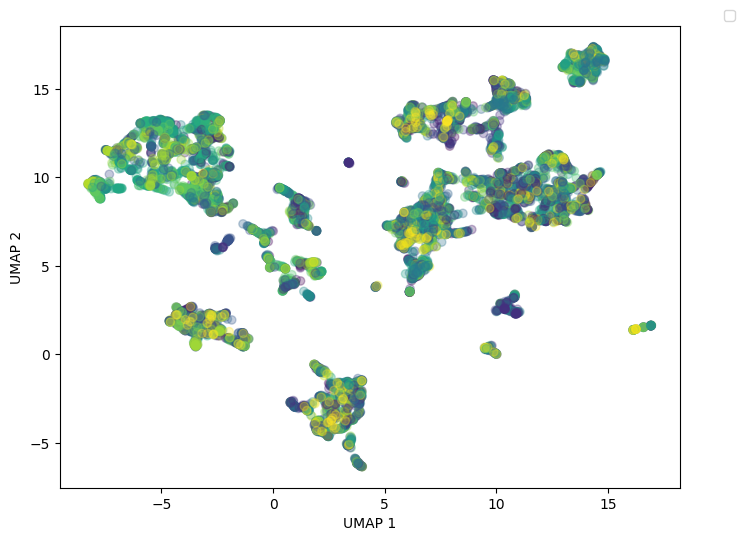

In [50]:
plt.figure(figsize=(8, 6))

scatter = plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    alpha=0.3,
    c=mouse_name_numbers,
    cmap='viridis'  # Choose a colormap
)   #     c=mouse_name_numbers,

# # Create the custom legend
# handles = []
# for code, label in zip(unique_numeric_labels, use_order):
#     handles.append(plt.Line2D([], [], marker='o', color=scatter.cmap(scatter.norm(code)), linestyle='', label=label))

plt.legend(bbox_to_anchor=(1.1, 1.05))
# plt.legend(handles=handles, title="Trial type", bbox_to_anchor=(1.1, 1.05))
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
# plt.xlim([-15, 25])
# plt.gca().set_aspect('equal', 'datalim')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'UMAP 2')

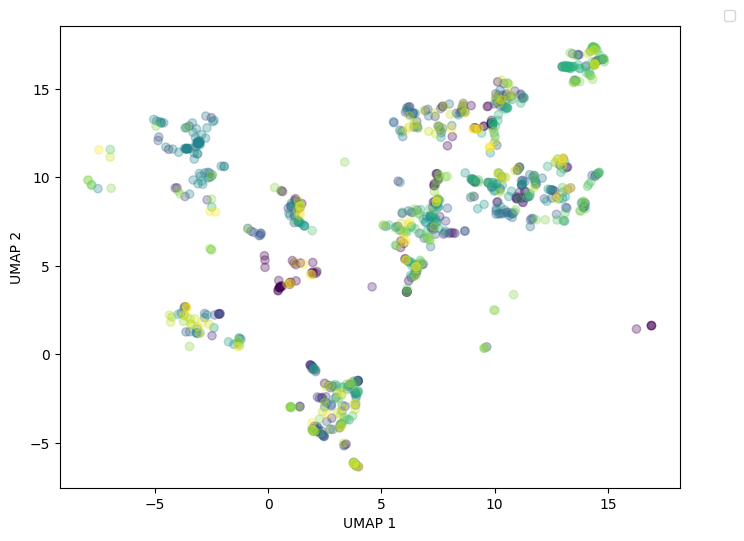

In [51]:
plt.figure(figsize=(8, 6))

scatter = plt.scatter(
    embedding[:, 0][0:1000],
    embedding[:, 1][0:1000],
    alpha=0.3,
    c=mouse_name_numbers[0:1000],
    cmap='viridis'  # Choose a colormap
)   #     c=mouse_name_numbers,

# # Create the custom legend
# handles = []
# for code, label in zip(unique_numeric_labels, use_order):
#     handles.append(plt.Line2D([], [], marker='o', color=scatter.cmap(scatter.norm(code)), linestyle='', label=label))

plt.legend(bbox_to_anchor=(1.1, 1.05))
# plt.legend(handles=handles, title="Trial type", bbox_to_anchor=(1.1, 1.05))
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
# plt.xlim([-15, 25])
# plt.gca().set_aspect('equal', 'datalim')


Text(0, 0.5, 'UMAP 2')

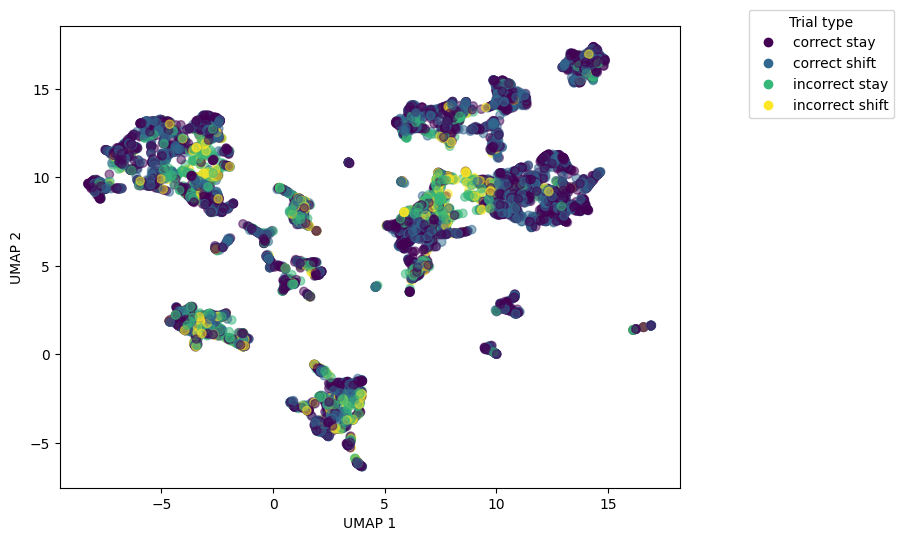

In [53]:
plt.figure(figsize=(8, 6))
filter = merged_df['trial_type'].isin(['incorrect stay', 'incorrect shift'])
filter = merged_df['trial_type'].isin(['correct stay', 'correct shift', 'incorrect stay', 'incorrect shift'])

# Plotting the scatter plot
scatter = plt.scatter(
    embedding[:, 0][filter],
    embedding[:, 1][filter],
    c=merged_df.loc[filter, 'numeric_trial_code'],
    alpha=0.5,
    cmap='viridis'  # Choose a colormap
)  

# Create the custom legend
handles = []
for code, label in zip(unique_numeric_labels[0:], use_order[0:]):
    handles.append(plt.Line2D([], [], marker='o', color=scatter.cmap(scatter.norm(code)), linestyle='', label=label))

# x.legend(bbox_to_anchor=(1.1, 1.05))
plt.legend(handles=handles, title="Trial type", bbox_to_anchor=(1.1, 1.05))
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
# plt.xlim([-15, 25])
# plt.gca().set_aspect('equal', 'datalim')



## K-means clustering of data

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


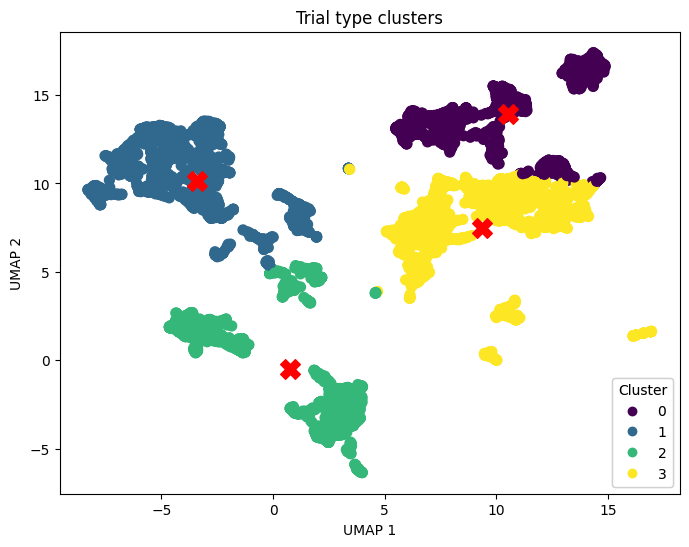

In [54]:
# Step 2: Perform KMeans Clustering
data_2d = embedding
kmeans = KMeans(n_clusters=4, random_state=2024)
kmeans.fit(data_2d)
y_kmeans = kmeans.predict(data_2d)

# Step 3: Plot the clusters
fig, ax = plt.subplots(figsize=(8, 6))

# Plot each cluster with a different color
scatter = ax.scatter(data_2d[:, 0], data_2d[:, 1], c=y_kmeans, s=50, cmap='viridis')

# Plot the centroids
centroids = kmeans.cluster_centers_
dots = ax.scatter(centroids[:, 0], centroids[:, 1], s=200, c='red', marker='X')

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower right", title="Cluster")
ax.add_artist(legend1)

plt.title("Trial type clusters")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


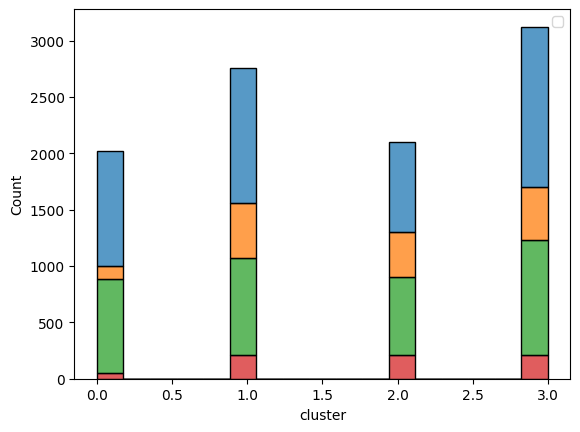

In [55]:
merged_df['cluster'] = y_kmeans
sns.histplot(x='cluster', hue='trial_type', data=merged_df, multiple='stack')
plt.legend()

In [56]:
# Analyze state features
merged_df['cluster'] = y_kmeans
df_cluster = count.reset_index().merge(merged_df[['sample', 'cluster']], on='sample')
# df_cluster = df_cluster.merge(sum[['sample', 'broader_label', 'sum']], on=['sample', 'broader_label'])
df_cluster = df_cluster.merge(times[['sample', 'reaction', 'response', 
                                     'elongation']], on=['sample'])

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_86808/3641596897.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['trial_type'] = pd.Categorical(use_data['trial_type'], categories = order_2)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


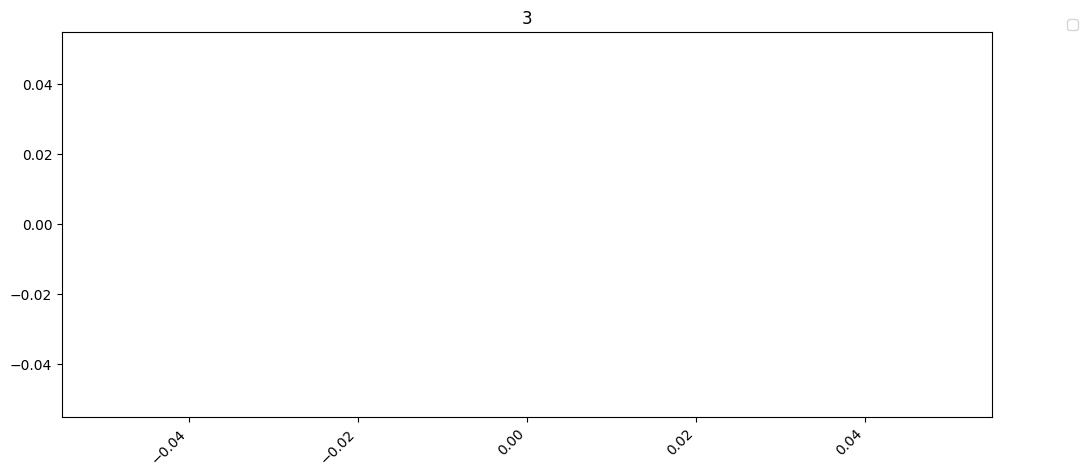

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_86808/3641596897.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['trial_type'] = pd.Categorical(use_data['trial_type'], categories = order_2)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


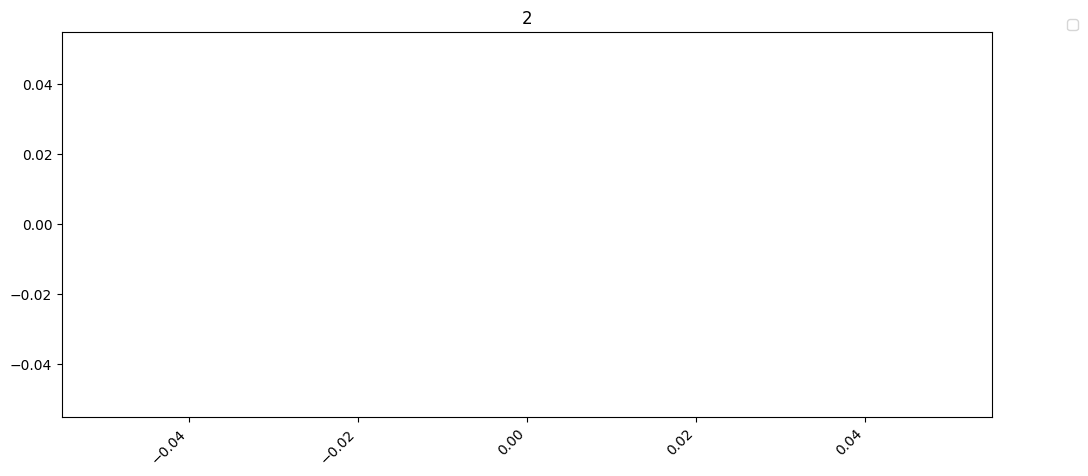

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_86808/3641596897.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['trial_type'] = pd.Categorical(use_data['trial_type'], categories = order_2)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


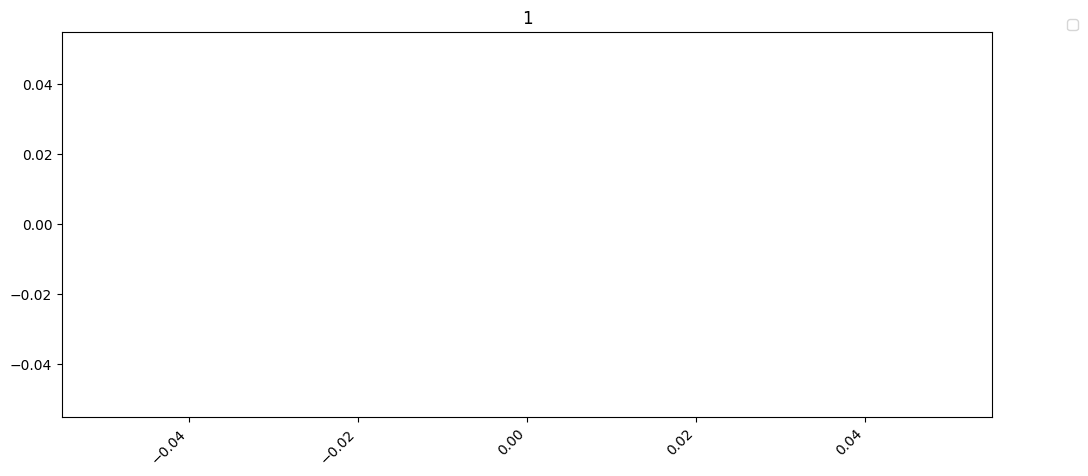

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_86808/3641596897.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['trial_type'] = pd.Categorical(use_data['trial_type'], categories = order_2)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


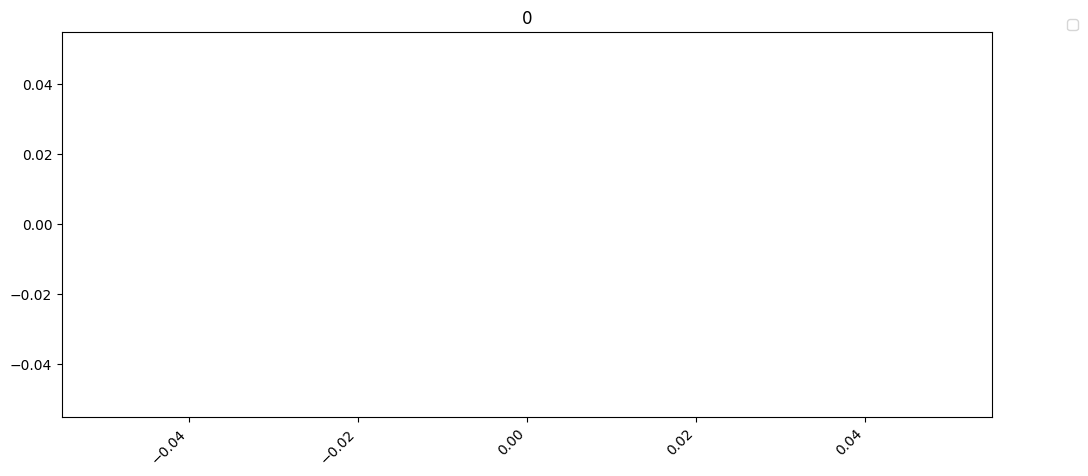

In [23]:
for c, cluster in enumerate(df_cluster['cluster'].unique()):
    use_data = df_cluster.loc[df_cluster['cluster']==cluster]
    fig, ax = plt.subplots(figsize=(12, 5))

    use_data['trial_type'] = pd.Categorical(use_data['trial_type'], categories = order_2)
    sns.histplot(x='trial_type', data=use_data, stat='probability')
    plt.xticks(rotation=45, ha='right')
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.title(cluster)
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


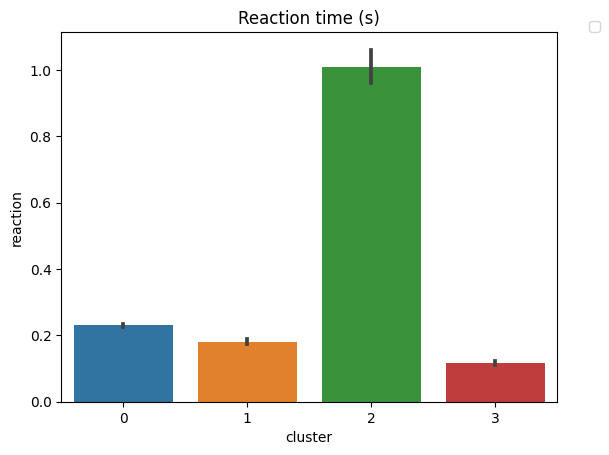

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


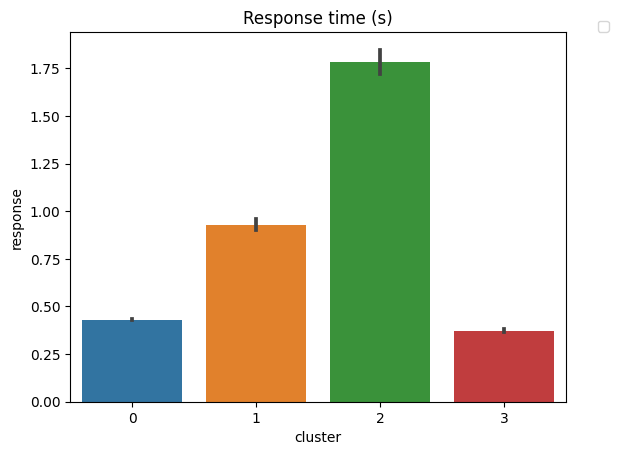

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


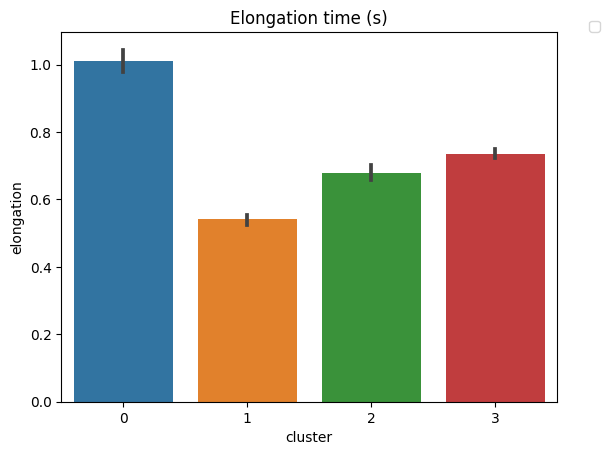

In [57]:
sns.barplot(x='cluster', y='reaction', data=df_cluster)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Reaction time (s)')
plt.show()

sns.barplot(x='cluster', y='response', data=df_cluster)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Response time (s)')
plt.show()

sns.barplot(x='cluster', y='elongation', data=df_cluster)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Elongation time (s)')
plt.show()


In [43]:
sns.barplot(x='broader_label', y='sum', hue='cluster', data=df_cluster)
plt.legend(bbox_to_anchor=(1.1, 1.05))

ValueError: Could not interpret input 'sum'

In [58]:
df_cluster.identifiable_states.unique()

array(['000', 'B11', '011', 'B01', 'B00', 'n11', 'n00', 'n01', 'b11',
       'b01', 'b00', '001', 'B10', 'n10', 'b10', '010'], dtype=object)

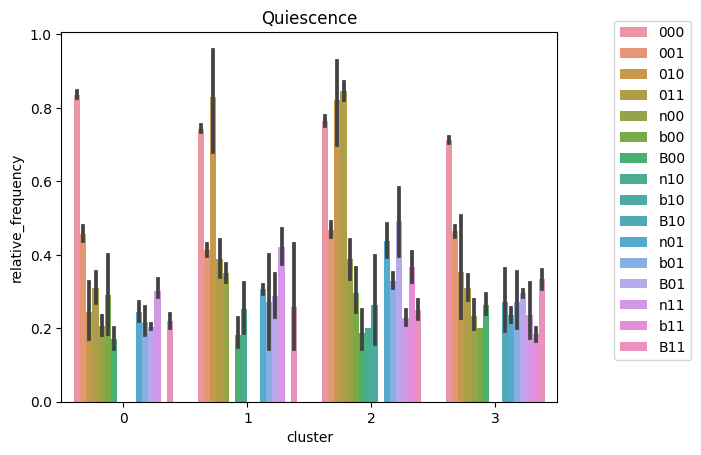

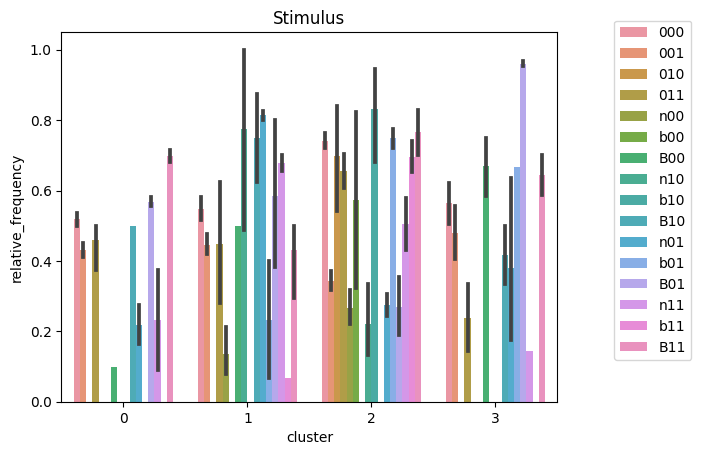

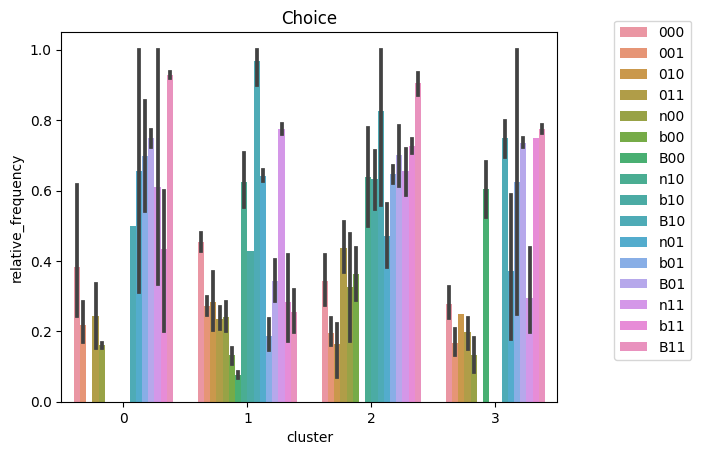

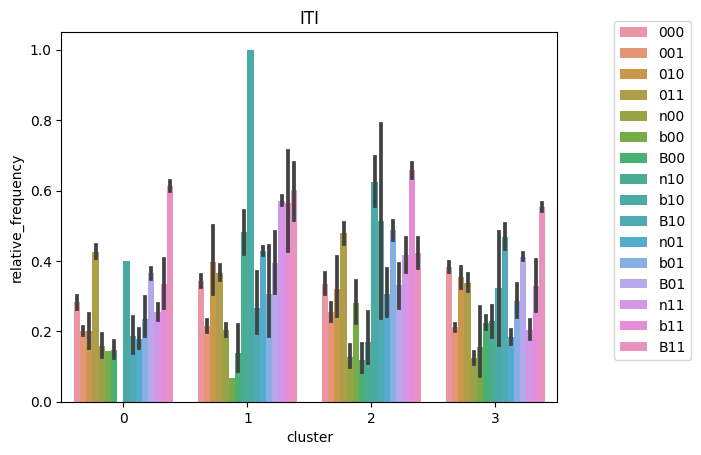

In [59]:
for e, epoch in enumerate(df_cluster['broader_label'].unique()):
    use_data = df_cluster.loc[df_cluster['broader_label']==epoch]
    sns.barplot(hue='identifiable_states', y='relative_frequency', x='cluster', 
                hue_order = ['000', '001', '010', '011', 'n00', 'b00', 'B00',
                             'n10', 'b10', 'B10', 'n01', 'b01', 'B01', 'n11', 'b11', 'B11'], data=use_data)
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.title(epoch)
    plt.show()

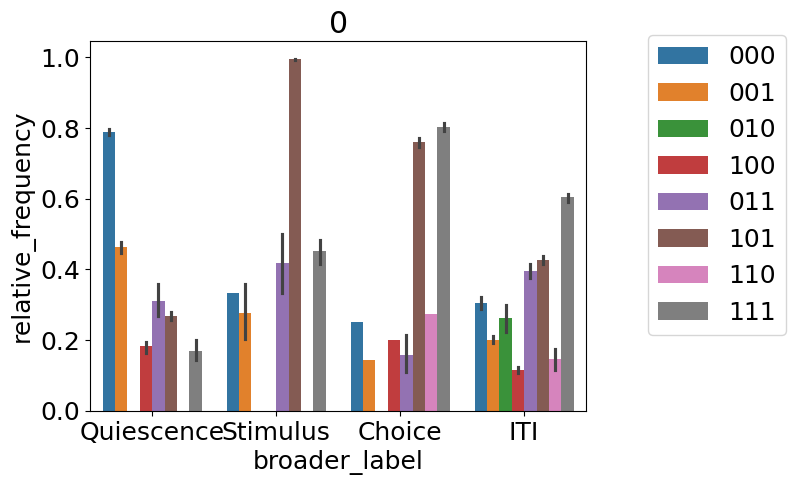

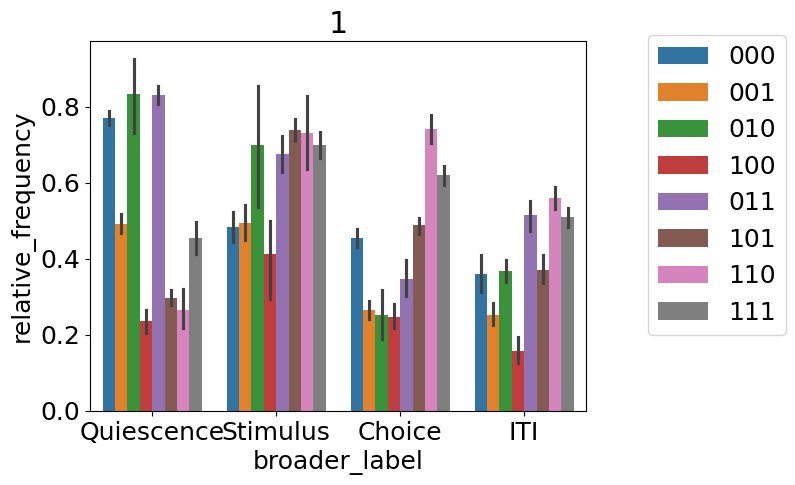

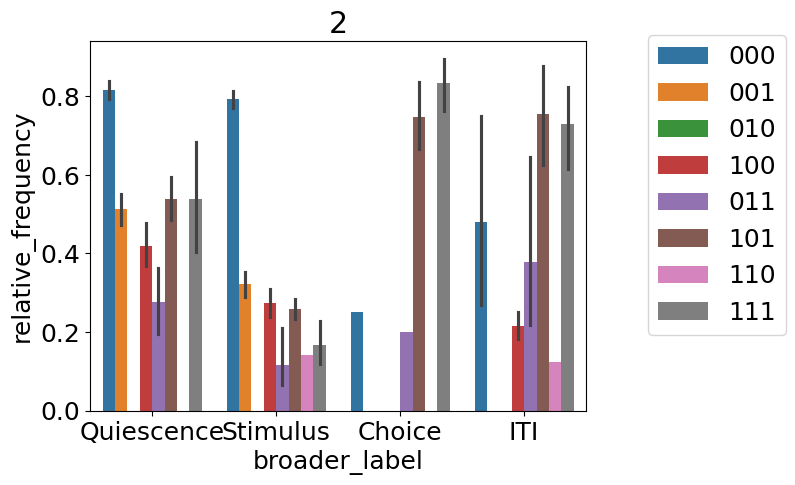

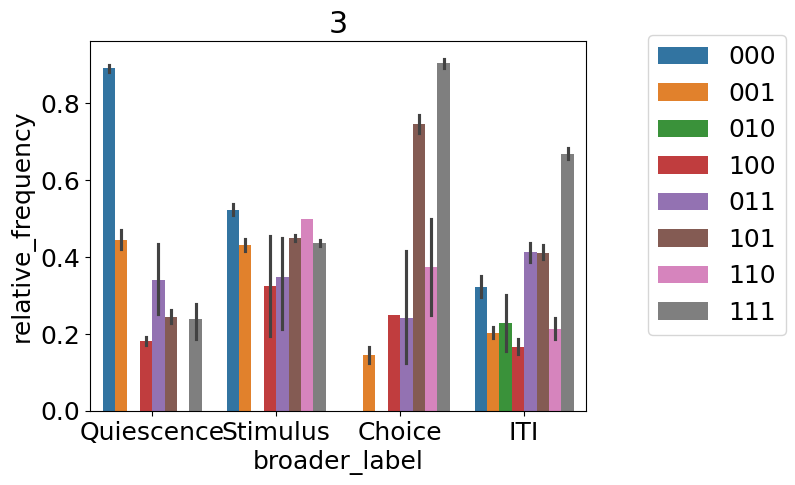

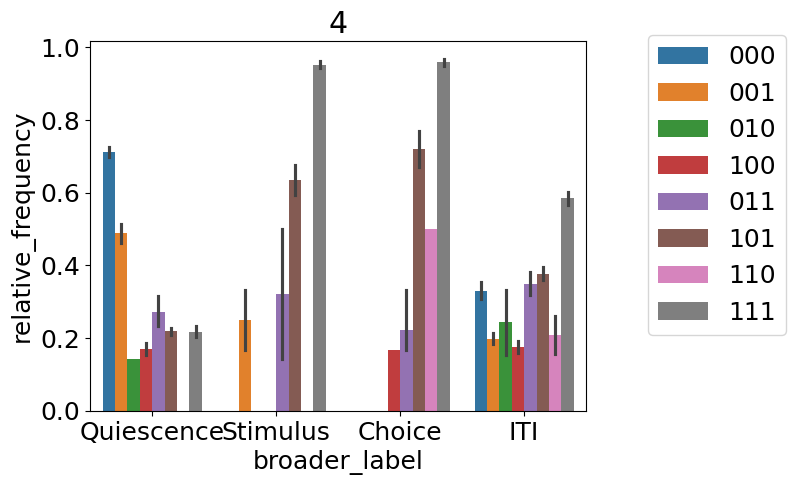

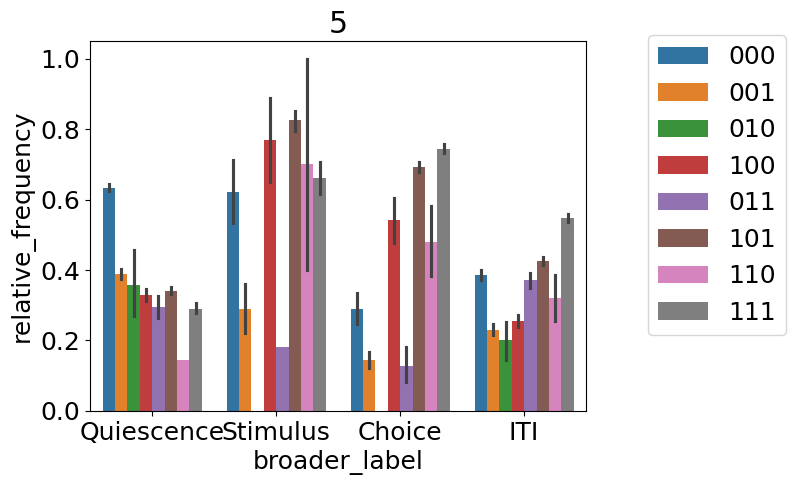

In [264]:
for c, cluster in enumerate(range(6)):
    use_data = df_cluster.loc[df_cluster['cluster']==cluster]
    sns.barplot(x='broader_label', y='relative_frequency', hue='identifiable_states', 
                order=['Quiescence', 'Stimulus', 'Choice', 'ITI'], 
                hue_order = ['000', '001', '010', '100', '011', '101', '110', '111'], data=use_data)
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.title(cluster)
    plt.show()